# 0001.01 Data - Clean Football Data Co Uk Data

In [1]:
import pathlib
import sys
import datetime

import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
# add the 'src' directory to path to import modules
src_dir = pathlib.Path().cwd().resolve().parent / 'src'
#src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)
# import my class code from the source
# %aimport src-dir.filename

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

PROJECT_DIR = pathlib.Path().cwd().resolve().parent

RAW_DATA_DIR = PROJECT_DIR / 'data' / '01-raw'
CLEANED_DIR = PROJECT_DIR / 'data' / '02-cleaned'

# CLEANED_DATA_DIR = DATA_DIR / '02-cleaned'

### Interpretation Notes for football-data.co.uk Data Files


[Interpretation Notes for football-data-co.uk data files](../data/reference/notes.txt)

## Select Raw Data Source, League and Seasons

In [2]:
# Specify scope of data for cleaning
source = 'football-data'
nation = 'united-kingdom'
league = 'english-premier-league'
seasons = ['2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013',
           '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018']

In [3]:
def form_fdcu_fps(RAW_DATA_DIR, source, nation, league, seasons):
    """
    Accepts directory names to enable reach into raw data directory
    Returns full filepaths of the data files
    """
    fps = []
    fdcu_specifics = ['football-data-co-uk', 'season-data']
    for season in seasons:
        fn = season + '.csv'
        stub = RAW_DATA_DIR / source / nation / league / season
        fp = stub / fdcu_specifics[0] / fdcu_specifics[1] / fn
        #if fp.is_file():
        if fp.exists():
            fps.append(fp)
    return fps

fp = form_fdcu_fps(RAW_DATA_DIR, source, nation, league, seasons)
fp[0]

PosixPath('/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/01-raw/football-data/united-kingdom/english-premier-league/2008-2009/football-data-co-uk/season-data/2008-2009.csv')

## Select the Top 16 European Leagues by Attendance

https://en.wikipedia.org/wiki/List_of_attendance_figures_at_domestic_professional_sports_leagues#Outdoor_sports

Referenced on 30 November 2019

In [4]:
nations = ['germany', 'united-kingdom', 'spain', 'italy',
          'france', 'united-kingdom', 'germany', 'netherlands',
          'russian-federation', 'scotland', 'portugal', 'switzerland',
          'belgium', 'turkey', 'poland', 'united-kingdom']

# poland, switzerland are multileague

leagues = ['bundesliga', 'english-premier-league', 'la-liga', 'serie-a',
           'ligue-1', 'english-championship', 'bundesliga-2', 'eredivisie',
           'premier-league', 'premiership', 'primeira-liga', 'super-league',
           'first-division-a', 'super-lig', 'ekstraklasa', 'one']

seasons = ['2000-2001', '2001-2002', '2002-2003', '2003-2004',
           '2004-2005', '2005-2006', '2006-2007', '2007-2008',
           '2008-2009', '2009-2010', '2010-2011', '2011-2012',
           '2012-2013', '2013-2014', '2014-2015', '2015-2016',
           '2016-2017', '2017-2018']

In [5]:
all_fps = []
for nation, league in zip(nations, leagues):
    fps = form_fdcu_fps(RAW_DATA_DIR, source, nation, league, seasons)
    all_fps.extend(fps)

print(len(all_fps))

226


In [6]:
def read_helper(fp, df):
    strfp = str(fp)
    season = fp.stem
    nation=strfp.split('/')[11]
    league = strfp.split('/')[12]
    df['nation'] = nation
    df['league'] = league
    df['season'] = season
    return df
    
    

good_season_dfs=[]
bad_season_dfs = []
for fp in all_fps:

    try:
        # Note: dayfirst=True
        season_df = pd.read_csv(fp, dayfirst=True, parse_dates=['Date'],
                                engine='python', error_bad_lines=True, encoding="ISO-8859-1")
        season_df = read_helper(fp, season_df)
        good_season_dfs.append(season_df)
    except:
        # https://stackoverflow.com/questions/55188544/pandas-how-to-workaround-error-tokenizing-data
        # Skipping line 17: Expected 59 fields in line 17, saw 65
        season_df = pd.read_csv(fp, header=None, sep='\n', encoding="ISO-8859-1")
        season_df = season_df[0].str.split(',', expand=True)
        season_df = read_helper(fp, season_df)
        bad_season_dfs.append(season_df)

df_orig = pd.concat(good_season_dfs, axis=0, sort=True)    
df_orig.head()

,ABP,AC,AF,AFKC,AG,AHW,AO,AR,AS,AST,AY,Attendance,AvgA,AvgD,AvgH,Away,AwayTeam,B365<2.5,B365>2.5,B365A,B365AH,B365AHA,B365AHH,B365D,B365H,BSA,BSD,BSH,BWA,BWD,BWH,Bb1X2,BbAH,BbAHh,BbAv<2.5,BbAv>2.5,BbAvA,BbAvAHA,BbAvAHH,BbAvD,BbAvH,BbMx<2.5,BbMx>2.5,BbMxA,BbMxAHA,BbMxAHH,BbMxD,BbMxH,BbOU,Country,Date,Div,FTAG,FTHG,FTR,GB<2.5,GB>2.5,GBA,GBAH,GBAHA,GBAHH,GBD,GBH,HBP,HC,HF,HFKC,HG,HHW,HO,HR,HS,HST,HTAG,HTHG,HTR,HY,Home,HomeTeam,IWA,IWD,IWH,LBA,LBAH,LBAHA,LBAHH,LBD,LBH,League,MaxA,MaxD,MaxH,PA,PD,PH,PSA,PSCA,PSCD,PSCH,PSD,PSH,Referee,Res,SBA,SBD,SBH,SJA,SJD,SJH,SOA,SOD,SOH,SYA,SYD,SYH,Season,Time,Unnamed: 25,Unnamed: 26,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 70,Unnamed: 71,Unnamed: 72,VCA,VCD,VCH,WHA,WHD,WHH,league,nation,season
0,50.0,3.0,19.0,NaN,NaN,0.0,8.0,0.0,5.0,2.0,5.0,61000.0,NaN,NaN,NaN,NaN,Hansa Rostock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-08-11,D1,0.0,1.0,H,NaN,NaN,5.0,NaN,NaN,NaN,3.4,1.5,10.0,7.0,25.0,NaN,NaN,0.0,4.0,0.0,17.0,7.0,0.0,0.0,D,1.0,NaN,Dortmund,5.0,3.5,1.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jörg Kessler,NaN,6.00,3.50,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,3.6,1.44,bundesliga,germany,2000-2001
1,0.0,9.0,12.0,NaN,NaN,0.0,3.0,0.0,11.0,5.0,0.0,57000.0,NaN,NaN,NaN,NaN,Hertha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-08-12,D1,1.0,4.0,H,NaN,NaN,6.0,NaN,NaN,NaN,4.5,1.3,10.0,4.0,13.0,NaN,NaN,1.0,3.0,0.0,14.0,6.0,0.0,1.0,H,1.0,NaN,Bayern Munich,5.0,3.5,1.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Markus Merk,NaN,7.00,3.75,1.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,3.6,1.44,bundesliga,germany,2000-2001
2,10.0,7.0,17.0,NaN,NaN,0.0,0.0,0.0,18.0,5.0,1.0,22500.0,NaN,NaN,NaN,NaN,Stuttgart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-08-12,D1,0.0,4.0,H,NaN,NaN,2.5,NaN,NaN,NaN,3.1,2.4,10.0,4.0,22.0,NaN,NaN,0.0,0.0,0.0,15.0,7.0,0.0,2.0,H,1.0,NaN,Freiburg,2.5,2.9,2.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Helmut Krug,NaN,2.38,3.25,2.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,3.2,2.40,bundesliga,germany,2000-2001
3,45.0,3.0,0.0,NaN,NaN,0.0,0.0,1.0,9.0,7.0,2.0,35000.0,NaN,NaN,NaN,NaN,Munich 1860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-08-12,D1,2.0,2.0,D,NaN,NaN,3.8,NaN,NaN,NaN,3.3,1.8,20.0,5.0,0.0,NaN,NaN,1.0,0.0,0.0,18.0,5.0,2.0,2.0,D,2.0,NaN,Hamburg,3.5,3.0,1.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Herbert Fandel,NaN,4.00,3.30,1.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,3.3,1.66,bundesliga,germany,2000-2001
4,0.0,5.0,8.0,NaN,NaN,0.0,0.0,0.0,5.0,2.0,0.0,38000.0,NaN,NaN,NaN,NaN,Bochum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [7]:
df_orig.shape

(72697, 162)

In [8]:
# Drop any columns that are all null
df_orig = df_orig.dropna(axis=1, how='all')
df_orig.shape

(72697, 126)

In [9]:
df_orig.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72697 entries, 0 to 551
Data columns (total 126 columns):
ABP           4646 non-null float64
AC            47772 non-null float64
AF            47150 non-null float64
AFKC          240 non-null float64
AG            1464 non-null float64
AHW           4482 non-null float64
AO            4483 non-null float64
AR            48326 non-null float64
AS            48147 non-null float64
AST           47535 non-null float64
AY            48326 non-null float64
Attendance    4634 non-null float64
AvgA          1464 non-null float64
AvgD          1464 non-null float64
AvgH          1464 non-null float64
Away          1464 non-null object
AwayTeam      71208 non-null object
B365<2.5      1159 non-null float64
B365>2.5      1159 non-null float64
B365A         62055 non-null float64
B365AH        2032 non-null float64
B365AHA       2032 non-null float64
B365AHH       2032 non-null float64
B365D         62055 non-null float64
B365H         62055 no

In [10]:
# Looks like there are differently named columns for the same thing
# i.e Away, Away team and Home, Home Team
# and for Goals AG and FTAG, and HG and FTHG
df_orig['AwayTeam'] = df_orig['AwayTeam'].fillna(df_orig['Away'])
df_orig['HomeTeam'] = df_orig['HomeTeam'].fillna(df_orig['Home'])
df_orig['FTHG'] = df_orig['FTHG'].fillna(df_orig['HG'])
df_orig['FTAG'] = df_orig['FTAG'].fillna(df_orig['AG'])
df_orig['FTR'] = df_orig['FTR'].fillna(df_orig['Res'])

df_orig['PSH'] = df_orig['PSH'].fillna(df_orig['PH'])
df_orig['PSD'] = df_orig['PSD'].fillna(df_orig['PD'])
df_orig['PSA'] = df_orig['PSA'].fillna(df_orig['PA'])


df_orig[['league', 'AwayTeam', 'Away', 'HomeTeam', 'Home', 'FTHG', 'HG', 'FTAG', 'AG', 'FTR', 'Res']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72697 entries, 0 to 551
Data columns (total 11 columns):
league      72697 non-null object
AwayTeam    72672 non-null object
Away        1464 non-null object
HomeTeam    72672 non-null object
Home        1464 non-null object
FTHG        72672 non-null float64
HG          1464 non-null float64
FTAG        72672 non-null float64
AG          1464 non-null float64
FTR         72672 non-null object
Res         1464 non-null object
dtypes: float64(4), object(7)
memory usage: 6.7+ MB


In [11]:
df_orig = df_orig.drop(columns=['Away', 'Home', 'HG', 'AG', 'Res'])

In [12]:
# looks like we have got some missing team names
# If everything else is mt, these may be mt lines at the bottom of the csvs
df_1 = df_orig[df_orig['AwayTeam'].isnull()]
df_1.head(30)

,ABP,AC,AF,AFKC,AHW,AO,AR,AS,AST,AY,Attendance,AvgA,AvgD,AvgH,AwayTeam,B365<2.5,B365>2.5,B365A,B365AH,B365AHA,B365AHH,B365D,B365H,BSA,BSD,BSH,BWA,BWD,BWH,Bb1X2,BbAH,BbAHh,BbAv<2.5,BbAv>2.5,BbAvA,BbAvAHA,BbAvAHH,BbAvD,BbAvH,BbMx<2.5,BbMx>2.5,BbMxA,BbMxAHA,BbMxAHH,BbMxD,BbMxH,BbOU,Country,Date,Div,FTAG,FTHG,FTR,GB<2.5,GB>2.5,GBA,GBAH,GBAHA,GBAHH,GBD,GBH,HBP,HC,HF,HFKC,HHW,HO,HR,HS,HST,HTAG,HTHG,HTR,HY,HomeTeam,IWA,IWD,IWH,LBA,LBAH,LBAHA,LBAHH,LBD,LBH,League,MaxA,MaxD,MaxH,PA,PD,PH,PSA,PSCA,PSCD,PSCH,PSD,PSH,Referee,SBA,SBD,SBH,SJA,SJD,SJH,SOA,SOD,SOH,SYA,SYD,SYH,Season,Time,VCA,VCD,VCH,WHA,WHD,WHH,league,nation,season
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,serie-a,italy,2012-2013
381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,serie-a,italy,2012-2013
382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,serie-a,italy,2012-2013
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,serie-a,italy,2014-2015
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,serie-a,italy,2015-2016
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ligue-1,france,2013-2014
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [13]:
# These are full of nans - Drop these
df_2 = df_orig[~df_orig['AwayTeam'].isnull()]

In [14]:
df_2.shape

(72672, 121)

In [15]:
# Drop columns we definitely do not want
df_2 = df_2.drop(columns=['Attendance', 'Country', 'Div', 'Season', 'Time', 'ABP', 'HBP', 'Referee', 'HTR'])
df_2 = df_2.sort_values(by=['nation', 'league', 'season'])

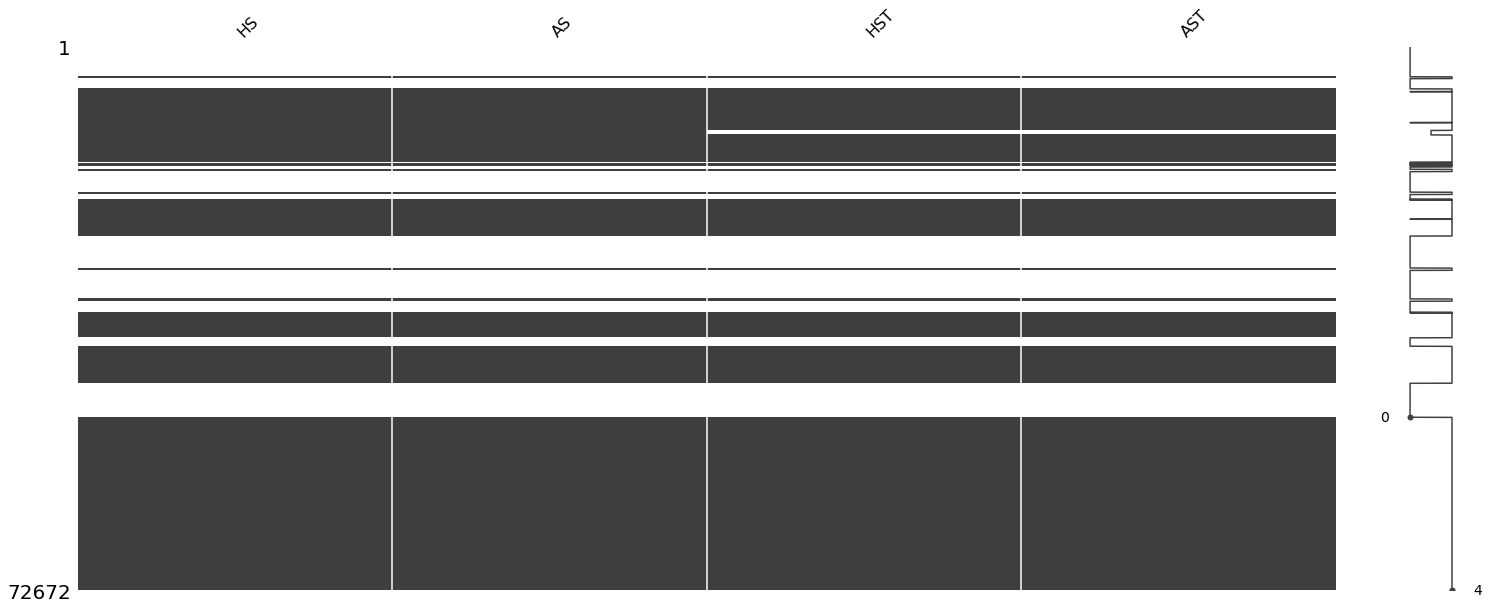

In [16]:
# we definitely want to use better features than just goals
# Definitely want to use Shots and Shots on target
# These are coded as HS, AS, HST, AST
msno.matrix(df_2[['HS', 'AS', 'HST', 'AST']])
plt.show();

In [17]:
# We pre-sorted by nation, league, season so it appears that the missing blocks are by season.
# it also seems like there is less Shots on target data, than there is in the shots data, so, we will
# Drop any season that have got missing values for HST, or AST 

In [18]:
st_dfs=[]
for (nation, league, season), df in df_2.groupby(by=['nation', 'league', 'season']):
    if df[['HST', 'AST']].isnull().sum().sum() == 0:
          st_dfs.append(df)

In [19]:
df_cut = pd.concat(st_dfs, axis=0)

In [20]:
df_3 = df_cut.copy(deep=True)
df_3 = df_3.dropna(axis=1, how='all')
df_3 = df_3.sort_values(by=['nation', 'league', 'season'])
df_3.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45358 entries, 0 to 551
Data columns (total 102 columns):
AC          45358 non-null float64
AF          44736 non-null float64
AFKC        240 non-null float64
AHW         3808 non-null float64
AO          3808 non-null float64
AR          45358 non-null float64
AS          45358 non-null float64
AST         45358 non-null float64
AY          45358 non-null float64
AwayTeam    45358 non-null object
B365<2.5    511 non-null float64
B365>2.5    511 non-null float64
B365A       41542 non-null float64
B365AH      526 non-null float64
B365AHA     526 non-null float64
B365AHH     526 non-null float64
B365D       41542 non-null float64
B365H       41542 non-null float64
BSA         18546 non-null float64
BSD         18546 non-null float64
BSH         18546 non-null float64
BWA         40968 non-null float64
BWD         40968 non-null float64
BWH         40968 non-null float64
Bb1X2       40988 non-null float64
BbAH        40918 non-null float

In [21]:
# Looks like there are 42200 potential records

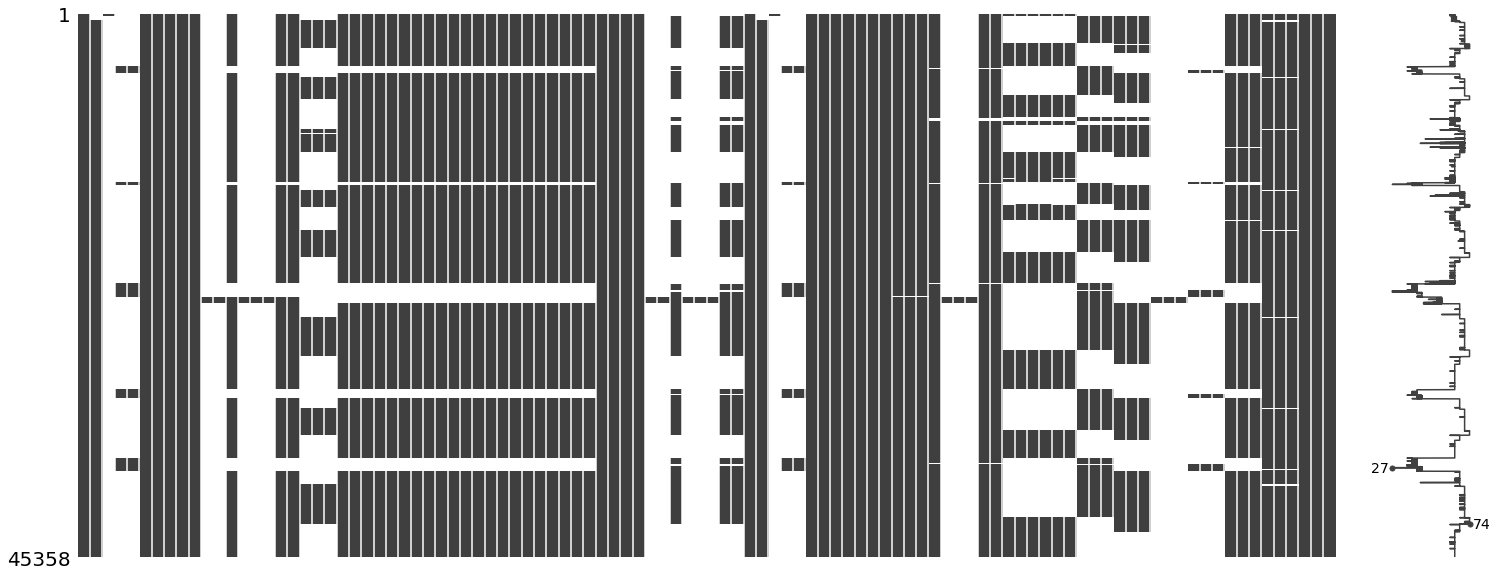

In [22]:
# We have sorted on nation., league and season
# remove the full columns, and review how the nulls fit into the overall dataframe

#df_null_cols = df_3[df_3.columns[df_3.isnull().any()]]
msno.matrix(df_3)
plt.show();

In [23]:
df_3_full_cols = df_3[df_3.columns[~df_3.isnull().any()]]
df_3_full_cols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45358 entries, 0 to 551
Data columns (total 18 columns):
AC          45358 non-null float64
AR          45358 non-null float64
AS          45358 non-null float64
AST         45358 non-null float64
AY          45358 non-null float64
AwayTeam    45358 non-null object
Date        45358 non-null datetime64[ns]
FTAG        45358 non-null float64
FTHG        45358 non-null float64
FTR         45358 non-null object
HC          45358 non-null float64
HR          45358 non-null float64
HS          45358 non-null float64
HST         45358 non-null float64
HomeTeam    45358 non-null object
league      45358 non-null object
nation      45358 non-null object
season      45358 non-null object
dtypes: datetime64[ns](1), float64(11), object(6)
memory usage: 6.6+ MB


In [24]:
# We will be keeping all these so rename
rename_d = {'AC': 'a_corners', 'AR': 'a_redCards', 'AS': 'a_shots', 'AST': 'a_shotsOnTarget',
           'AY': 'a_yellowCards', 'AwayTeam': 'a',
            'Date': 'date', 'FTAG': 'a_ftGoals', 'FTHG': 'h_ftGoals', 'FTR': 'ftResult',
            'HC': 'h_corners', 'HR': 'h_redCards', 'HS': 'h_shots', 'HST': 'h_shotsOnTarget',
            'HY': 'h_yellowCards', 'HomeTeam': 'h',
           'HTAG': 'a_htGoals', 'HTHG': 'h_htGoals', 'AF': 'a_fouls', 'HF': 'h_fouls',
           'HHW': 'h_woodWork', 'AHW': 'a_woodWork',
           'AO': 'a_offsides', 'HO': 'h_offsides'}
df_3 = df_3.rename(columns=rename_d)

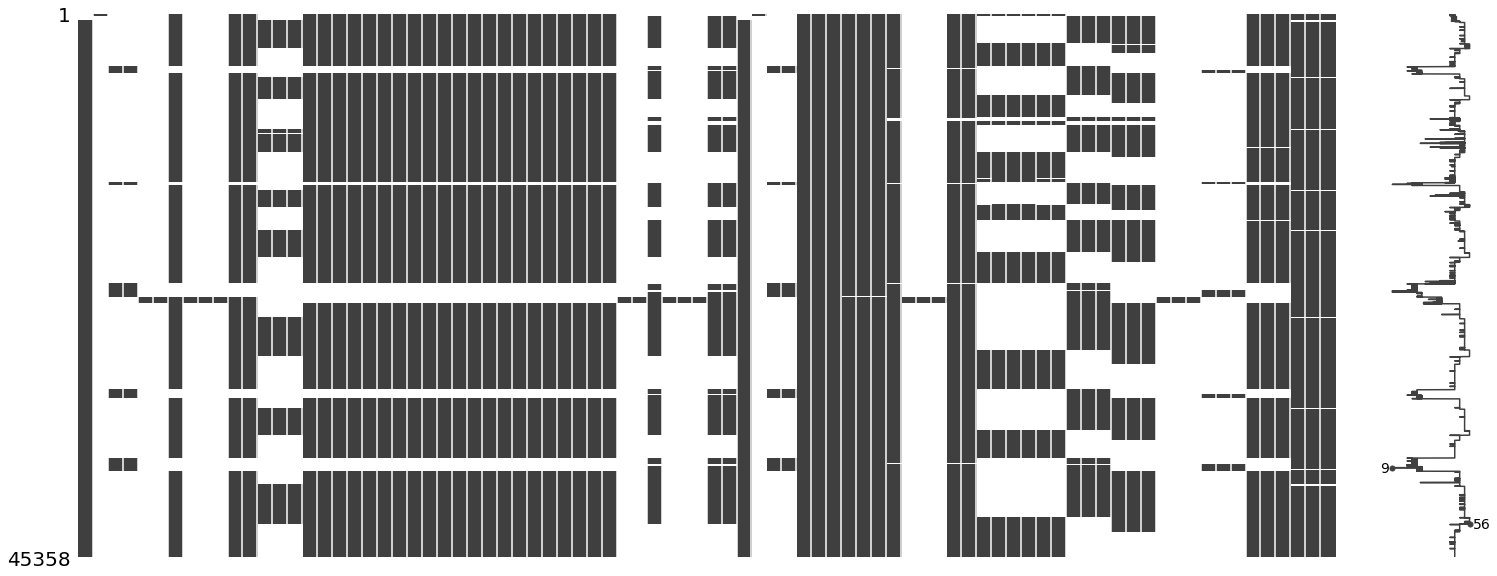

In [25]:
df_4 = df_3.copy(deep=True)
# df_null_cols = df[df.columns[df.isnull().any()]]
msno.matrix(df_4[df_4.columns[df_4.isnull().any()]])
plt.show();   
# for (nation, league, season), df in df_4.groupby(by=['nation', 'league', 'season']):
#     print(nation, league, season)
#     df_null_cols = df[df.columns[df.isnull().any()]]
#     msno.matrix(df_null_cols, figsize=(14,2))
#     plt.show();    

In [26]:
# take alook at the columns with any nulls
# A full column has 42200 values
my_cols = [col for col in df_4.columns if col not in list(rename_d.values())]
df_5 = df_4[my_cols]
df_5[df_5.columns[df_5.isnull().any()]].info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45358 entries, 0 to 551
Data columns (total 75 columns):
AFKC        240 non-null float64
B365<2.5    511 non-null float64
B365>2.5    511 non-null float64
B365A       41542 non-null float64
B365AH      526 non-null float64
B365AHA     526 non-null float64
B365AHH     526 non-null float64
B365D       41542 non-null float64
B365H       41542 non-null float64
BSA         18546 non-null float64
BSD         18546 non-null float64
BSH         18546 non-null float64
BWA         40968 non-null float64
BWD         40968 non-null float64
BWH         40968 non-null float64
Bb1X2       40988 non-null float64
BbAH        40918 non-null float64
BbAHh       40918 non-null float64
BbAv<2.5    40986 non-null float64
BbAv>2.5    40986 non-null float64
BbAvA       40988 non-null float64
BbAvAHA     40918 non-null float64
BbAvAHH     40918 non-null float64
BbAvD       40988 non-null float64
BbAvH       40988 non-null float64
BbMx<2.5    40986 non-null flo

In [27]:
# For each game, it would be ideal if, as well as the match statistics, we could have
# Mean odds, max odds, a full set of odds from a bookmaker, the closing odds
# 42200 Games
# 

In [28]:
bb_dfs=[]
for (nation, league, season), df in df_4.groupby(by=['nation', 'league', 'season']):
    if df[['BbMxH', 'BbMxD', 'BbMxA', 'B365A', 'B365D', 'B365H']].isnull().sum().sum() == 0:
          bb_dfs.append(df)

In [29]:
df_6 = pd.concat(bb_dfs)
df_6.info(verbose=True, null_counts=True)
#df_6[df_6.columns[~df_6.isnull().any()]].info(verbose=True, null_counts=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38086 entries, 0 to 551
Data columns (total 102 columns):
a_corners          38086 non-null float64
a_fouls            37464 non-null float64
AFKC               240 non-null float64
a_woodWork         0 non-null float64
a_offsides         0 non-null float64
a_redCards         38086 non-null float64
a_shots            38086 non-null float64
a_shotsOnTarget    38086 non-null float64
a_yellowCards      38086 non-null float64
a                  38086 non-null object
B365<2.5           0 non-null float64
B365>2.5           0 non-null float64
B365A              38086 non-null float64
B365AH             0 non-null float64
B365AHA            0 non-null float64
B365AHH            0 non-null float64
B365D              38086 non-null float64
B365H              38086 non-null float64
BSA                17190 non-null float64
BSD                17190 non-null float64
BSH                17190 non-null float64
BWA                38074 non-null float64

In [30]:
# Drop any columns with less than threshold
thresh = int(len(df_6) * 0.75)
df_7 = df_6.copy(deep=True)
df_7 = df_7.dropna(axis=1, thresh=thresh)
df_7.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38086 entries, 0 to 551
Data columns (total 59 columns):
a_corners          38086 non-null float64
a_fouls            37464 non-null float64
a_redCards         38086 non-null float64
a_shots            38086 non-null float64
a_shotsOnTarget    38086 non-null float64
a_yellowCards      38086 non-null float64
a                  38086 non-null object
B365A              38086 non-null float64
B365D              38086 non-null float64
B365H              38086 non-null float64
BWA                38074 non-null float64
BWD                38074 non-null float64
BWH                38074 non-null float64
Bb1X2              38086 non-null float64
BbAH               38016 non-null float64
BbAHh              38016 non-null float64
BbAv<2.5           38084 non-null float64
BbAv>2.5           38084 non-null float64
BbAvA              38086 non-null float64
BbAvAHA            38016 non-null float64
BbAvAHH            38016 non-null float64
BbAvD       

In [31]:
df = pd.concat([df_7, df_6[['PSCA', 'PSCD', 'PSCH']]], axis=1)

In [32]:
cols = [col for col in df.columns if not col.startswith(('h', 'a'))]#'h' not in col[0:2] or 'a' not in col[0:1]]
#or (col[0] != 'a')]
print(sorted(cols))
#df_7.columns#info(verbose=True, null_counts=True)

['B365A', 'B365D', 'B365H', 'BWA', 'BWD', 'BWH', 'Bb1X2', 'BbAH', 'BbAHh', 'BbAv<2.5', 'BbAv>2.5', 'BbAvA', 'BbAvAHA', 'BbAvAHH', 'BbAvD', 'BbAvH', 'BbMx<2.5', 'BbMx>2.5', 'BbMxA', 'BbMxAHA', 'BbMxAHH', 'BbMxD', 'BbMxH', 'BbOU', 'IWA', 'IWD', 'IWH', 'LBA', 'LBD', 'LBH', 'PSCA', 'PSCD', 'PSCH', 'VCA', 'VCD', 'VCH', 'WHA', 'WHD', 'WHH', 'date', 'ftResult', 'league', 'nation', 'season']


In [33]:
columns = {'B365H': 'odds_hwin_bet365', 'B365D': 'odds_draw_bet365', 'B365A': 'odds_awin_bet365',
            'BWH': 'odds_hwin_BW', 'BWD': 'odds_draw_BW', 'BWA': 'odds_awin_BW',
            'Bb1X2': 'n_Bb1X2', 'BbAH': 'n_BbAsian', 'BbAHh': 'BbAsian_handicap',
            'BbAv<2.5': 'odds_ftgoalsu2.5_bbmean', 'BbAv>2.5': 'odds_ftgoalso2.5_bbmean', 
            'BbAvA': 'odds_awin_bbmean',
            'BbAvAHA': 'odds_asianaway_bbmean', 'BbAvAHH': 'odds_asianhome_bbmean',
            'BbAvD': 'odds_draw_bbmean', 'BbAvH': 'odds_hwin_bbmean',
            'BbMx<2.5': 'odds_ftgoalsu2.5_bbmax', 'BbMx>2.5': 'odds_ftgoalso2.5_bbmax',
            'BbMxA': 'odds_awin_bbmax','BbMxAHA': 'odds_asianaway_bbmax', 'BbMxAHH': 'odds_asianhome_bbmax',
            'BbMxD': 'odds_draw_bbmax', 'BbMxH': 'odds_hwin_bbmax', 'BbOU': 'n_BbOU',
            'IWH': 'odds_hwin_IW', 'IWD': 'odds_draw_IW', 'IWA': 'odds_awin_IW',
            'LBH': 'odds_hwin_LB', 'LBD': 'odds_draw_LB', 'LBA': 'odds_awin_LB',
            'PSCH': 'clodds_hwin_pinn', 'PSCD': 'clodds_draw_pinn', 'PSCA': 'clodds_away_pinn',
            'VCH': 'odds_hwin_VC', 'VCD': 'odds_draw_VC', 'VCA': 'odds_awin_VC', 
            'WHH': 'odds_hwin_WH', 'WHD': 'odds_draw_WH', 'WHA': 'odds_awin_WH'}
df.rename(columns=columns, inplace=True)
df = df.reset_index(drop=True)

In [34]:
df.head()

,a_corners,a_fouls,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,a,odds_awin_bet365,odds_draw_bet365,odds_hwin_bet365,odds_awin_BW,odds_draw_BW,odds_hwin_BW,n_Bb1X2,n_BbAsian,BbAsian_handicap,odds_ftgoalsu2.5_bbmean,odds_ftgoalso2.5_bbmean,odds_awin_bbmean,odds_asianaway_bbmean,odds_asianhome_bbmean,odds_draw_bbmean,odds_hwin_bbmean,odds_ftgoalsu2.5_bbmax,odds_ftgoalso2.5_bbmax,odds_awin_bbmax,odds_asianaway_bbmax,odds_asianhome_bbmax,odds_draw_bbmax,odds_hwin_bbmax,n_BbOU,date,a_ftGoals,h_ftGoals,ftResult,h_corners,h_fouls,h_redCards,h_shots,h_shotsOnTarget,a_htGoals,h_htGoals,h_yellowCards,h,odds_awin_IW,odds_draw_IW,odds_hwin_IW,odds_awin_LB,odds_draw_LB,odds_hwin_LB,odds_awin_VC,odds_draw_VC,odds_hwin_VC,odds_awin_WH,odds_draw_WH,odds_hwin_WH,league,nation,season,clodds_away_pinn,clodds_draw_pinn,clodds_hwin_pinn
0,5.0,NaN,0.0,13.0,6.0,0.0,Anderlecht,1.60,3.80,5.75,1.67,4.0,5.00,36.0,19.0,1.00,1.95,1.83,1.60,2.04,1.81,3.86,5.46,2.04,1.90,1.70,2.10,1.87,4.14,6.11,34.0,2017-07-28,0.0,0.0,D,5.0,NaN,0.0,3.0,2.0,0.0,0.0,3.0,Antwerp,1.7,3.6,4.70,1.61,3.7,5.20,1.62,3.90,5.50,1.67,3.75,4.75,first-division-a,belgium,2017-2018,1.64,4.14,5.78
1,6.0,NaN,0.0,9.0,1.0,1.0,Kortrijk,5.50,3.75,1.62,5.50,3.7,1.67,40.0,18.0,-0.75,1.84,1.92,5.18,1.99,1.85,3.74,1.64,1.92,2.00,5.62,2.05,1.90,4.02,1.67,37.0,2017-07-29,0.0,1.0,H,5.0,NaN,0.0,6.0,2.0,0.0,1.0,2.0,Charleroi,5.4,3.7,1.60,5.20,3.6,1.61,5.25,3.80,1.65,4.80,3.75,1.65,first-division-a,belgium,2017-2018,5.49,4.01,1.68
2,7.0,NaN,0.0,13.0,9.0,2.0,Waregem,2.60,3.40,2.60,2.60,3.4,2.70,39.0,18.0,0.00,2.07,1.72,2.51,1.84,1.99,3.35,2.66,2.20,1.77,2.60,1.91,2.07,3.56,2.83,36.0,2017-07-29,5.0,0.0,A,2.0,NaN,0.0,3.0,1.0,1.0,0.0,2.0,Eupen,2.5,3.3,2.65,2.50,3.3,2.55,2.60,3.40,2.63,2.50,3.40,2.60,first-division-a,belgium,2017-2018,2.79,3.51,2.62
3,2.0,NaN,0.0,9.0,6.0,2.0,Waasland-Beveren,7.00,4.75,1.40,7.75,4.6,1.42,39.0,18.0,-1.25,2.16,1.64,7.72,1.99,1.86,4.60,1.38,2.25,1.67,8.96,2.04,1.91,5.17,1.44,29.0,2017-07-29,3.0,3.0,D,5.0,NaN,0.0,11.0,5.0,1.0,0.0,1.0,Genk,7.3,4.4,1.40,8.00,4.5,1.36,8.50,4.75,1.36,7.00,4.50,1.40,first-division-a,belgium,2017-2018,8.81,5.13,1.4
4,6.0,NaN,1.0,9.0,4.0,1.0,Club Brugge,1.83,3.60,4.20,1.83,3.7,4.25,40.0,18.0,0.50,1.93,1.83,1.83,1.84,2.00,3.56,4.09,2.01,1.92,1.93,1.89,2.06,3.78,4.33,37.0,2017-07-29,4.0,0.0,A,5.0,NaN,0.0,11.0,4.0,3.0,0.0,3.0,Lokeren,1.8,3.5,4.20,1.83,3.4,4.00,1.83,3.60,4.20,1.75,3.60,4.33,first-division-a,belgium,2017-2018,1.76,3.80,5.19


In [35]:
df.tail()

,a_corners,a_fouls,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,a,odds_awin_bet365,odds_draw_bet365,odds_hwin_bet365,odds_awin_BW,odds_draw_BW,odds_hwin_BW,n_Bb1X2,n_BbAsian,BbAsian_handicap,odds_ftgoalsu2.5_bbmean,odds_ftgoalso2.5_bbmean,odds_awin_bbmean,odds_asianaway_bbmean,odds_asianhome_bbmean,odds_draw_bbmean,odds_hwin_bbmean,odds_ftgoalsu2.5_bbmax,odds_ftgoalso2.5_bbmax,odds_awin_bbmax,odds_asianaway_bbmax,odds_asianhome_bbmax,odds_draw_bbmax,odds_hwin_bbmax,n_BbOU,date,a_ftGoals,h_ftGoals,ftResult,h_corners,h_fouls,h_redCards,h_shots,h_shotsOnTarget,a_htGoals,h_htGoals,h_yellowCards,h,odds_awin_IW,odds_draw_IW,odds_hwin_IW,odds_awin_LB,odds_draw_LB,odds_hwin_LB,odds_awin_VC,odds_draw_VC,odds_hwin_VC,odds_awin_WH,odds_draw_WH,odds_hwin_WH,league,nation,season,clodds_away_pinn,clodds_draw_pinn,clodds_hwin_pinn
38081,4.0,11.0,0.0,13.0,2.0,0.0,Charlton,3.50,3.79,2.10,3.40,3.5,2.05,42.0,18.0,-0.25,1.73,2.06,3.29,2.01,1.81,3.50,2.08,1.77,2.14,3.6,2.06,1.86,3.81,2.20,34.0,2018-05-05,0.0,1.0,H,4.0,14.0,0.0,12.0,5.0,0.0,0.0,1.0,Rochdale,3.25,3.25,2.00,3.2,3.5,2.10,3.30,3.70,2.15,3.5,3.4,2.05,one,united-kingdom,2017-2018,3.98,3.89,1.92
38082,6.0,10.0,0.0,13.0,4.0,0.0,Blackpool,2.87,3.60,2.50,2.65,3.5,2.45,42.0,18.0,-0.25,1.91,1.87,2.77,1.74,2.11,3.39,2.42,1.98,1.94,3.0,1.80,2.20,3.60,2.51,38.0,2018-05-05,0.0,1.0,H,5.0,7.0,0.0,15.0,3.0,0.0,0.0,1.0,Rotherham,2.65,3.20,2.35,2.8,3.3,2.45,2.75,3.60,2.50,2.9,3.3,2.40,one,united-kingdom,2017-2018,3.34,3.79,2.14
38083,4.0,19.0,0.0,16.0,5.0,0.0,Bradford,4.50,3.75,1.85,4.33,3.5,1.80,43.0,18.0,-0.50,1.81,1.96,4.07,1.96,1.86,3.50,1.86,1.88,2.03,4.5,2.01,1.93,3.75,1.92,39.0,2018-05-05,1.0,1.0,D,1.0,11.0,0.0,10.0,4.0,0.0,0.0,0.0,Scunthorpe,3.90,3.35,1.80,4.2,3.4,1.87,4.10,3.75,1.90,4.0,3.4,1.91,one,united-kingdom,2017-2018,4.21,3.68,1.92
38084,1.0,14.0,0.0,6.0,3.0,1.0,Milton Keynes Dons,4.50,4.00,1.80,4.25,3.6,1.78,42.0,17.0,-0.75,1.77,2.00,4.36,1.80,2.03,3.54,1.78,1.84,2.10,4.8,1.84,2.12,4.00,1.84,37.0,2018-05-05,1.0,0.0,A,7.0,15.0,0.0,8.0,1.0,0.0,0.0,1.0,Shrewsbury,4.20,3.35,1.75,4.5,3.5,1.80,4.50,3.80,1.80,4.5,3.5,1.80,one,united-kingdom,2017-2018,4.98,3.84,1.76
38085,2.0,9.0,1.0,6.0,2.0,1.0,Bristol Rvs,3.20,3.60,2.29,3.10,3.4,2.20,42.0,19.0,-0.25,1.98,1.79,3.03,1.87,1.95,3.42,2.23,2.09,1.88,3.2,1.95,2.03,3.65,2.31,37.0,2018-05-05,0.0,0.0,D,9.0,14.0,0.0,19.0,5.0,0.0,0.0,2.0,Southend,2.95,3.25,2.15,3.0,3.4,2.25,3.10,3.60,2.30,3.1,3.2,2.30,one,united-kingdom,2017-2018,3.16,3.78,2.23


In [36]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38086 entries, 0 to 38085
Data columns (total 62 columns):
a_corners                  38086 non-null float64
a_fouls                    37464 non-null float64
a_redCards                 38086 non-null float64
a_shots                    38086 non-null float64
a_shotsOnTarget            38086 non-null float64
a_yellowCards              38086 non-null float64
a                          38086 non-null object
odds_awin_bet365           38086 non-null float64
odds_draw_bet365           38086 non-null float64
odds_hwin_bet365           38086 non-null float64
odds_awin_BW               38074 non-null float64
odds_draw_BW               38074 non-null float64
odds_hwin_BW               38074 non-null float64
n_Bb1X2                    38086 non-null float64
n_BbAsian                  38016 non-null float64
BbAsian_handicap           38016 non-null float64
odds_ftgoalsu2.5_bbmean    38084 non-null float64
odds_ftgoalso2.5_bbmean    38084 non-null 

In [37]:
df.describe()

,a_corners,a_fouls,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,odds_awin_bet365,odds_draw_bet365,odds_hwin_bet365,odds_awin_BW,odds_draw_BW,odds_hwin_BW,n_Bb1X2,n_BbAsian,BbAsian_handicap,odds_ftgoalsu2.5_bbmean,odds_ftgoalso2.5_bbmean,odds_awin_bbmean,odds_asianaway_bbmean,odds_asianhome_bbmean,odds_draw_bbmean,odds_hwin_bbmean,odds_ftgoalsu2.5_bbmax,odds_ftgoalso2.5_bbmax,odds_awin_bbmax,odds_asianaway_bbmax,odds_asianhome_bbmax,odds_draw_bbmax,odds_hwin_bbmax,n_BbOU,a_ftGoals,h_ftGoals,h_corners,h_fouls,h_redCards,h_shots,h_shotsOnTarget,a_htGoals,h_htGoals,h_yellowCards,odds_awin_IW,odds_draw_IW,odds_hwin_IW,odds_awin_LB,odds_draw_LB,odds_hwin_LB,odds_awin_VC,odds_draw_VC,odds_hwin_VC,odds_awin_WH,odds_draw_WH,odds_hwin_WH,clodds_away_pinn,clodds_draw_pinn
count,38086.000000,37464.000000,38086.000000,38086.000000,38086.000000,38086.000000,38086.000000,38086.000000,38086.000000,38074.000000,38074.000000,38074.000000,38086.000000,38016.000000,38016.000000,38084.000000,38084.00000,38086.000000,38016.000000,38016.000000,38086.000000,38086.000000,38084.000000,38084.000000,38086.000000,38016.000000,38016.000000,38086.000000,38086.000000,38085.000000,38086.000000,38086.000000,38086.000000,37464.000000,38086.000000,38086.000000,38086.000000,38085.000000,38085.000000,38085.000000,38012.000000,38012.000000,38012.000000,38064.000000,38064.000000,38064.000000,38046.000000,38045.000000,38046.000000,37178.000000,37178.000000,37178.000000,18958.000000,18958.000000
mean,4.663157,13.453502,0.121331,10.542509,4.305283,1.965788,4.302398,3.712199,2.534281,4.082295,3.606881,2.463129,41.116946,20.741267,-0.295183,1.890885,1.92745,4.184388,2.004045,1.910475,3.631117,2.497328,1.992604,2.033179,4.781679,2.086599,1.977313,3.912588,2.693940,33.834239,1.149924,1.497716,5.862443,12.896194,0.086646,13.133120,5.414457,0.499173,0.662413,1.621032,3.840814,3.487025,2.392891,4.110231,3.602882,2.456903,4.358339,3.738706,2.546586,4.130469,3.538815,2.497825,4.663575,4.044832
std,2.615140,4.752764,0.352948,4.423482,2.517010,1.352182,3.241998,0.990801,1.556040,2.897448,0.947916,1.440879,6.778285,4.898306,0.651219,0.325265,0.23273,3.119360,0.524436,0.298896,0.950885,1.497031,0.372930,0.262156,4.311897,0.658067,0.348223,1.275076,1.828542,6.731224,1.115773,1.258661,2.979111,4.670287,0.298351,5.018106,2.872316,0.709095,0.813715,1.277007,2.531447,0.760728,1.272043,3.124141,0.909086,1.445434,3.616952,1.090867,1.630068,3.103746,0.859572,1.484317,4.244957,1.490181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.080000,1.400000,0.000000,1.090000,1.450000,1.030000,0.000000,1.000000,-3.500000,1.260000,1.09000,1.080000,1.020000,1.010000,1.440000,1.030000,1.290000,1.130000,1.100000,1.030000,1.010000,1.530000,1.050000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.050000,2.000000,1.030000,1.060000,1.400000,1.040000,1.080000,2.000000,1.030000,1.040000,1.020000,1.020000,1.080000,2.360000
25%,3.000000,10.000000,0.000000,7.000000,2.000000,1.000000,2.630000,3.250000,1.800000,2.600000,3.200000,1.750000,36.000000,17.000000,-0.500000,1.700000,1.78000,2.610000,1.840000,1.810000,3.230000,1.770000,1.780000,1.870000,2.780000,1.890000,1.870000,3.400000,1.850000,30.000000,0.000000,1.000000,4.000000,10.000000,0.000000,10.000000,3.000000,0.000000,0.000000,1.000000,2.500000,3.100000,1.750000,2.600000,3.200000,1.750000,2.620000,3.250000,1.800000,2.620000,3.200000,1.800000,2.600000,3.400000
50%,4.000000,13.000000,0.000000,10.000000,4.000000,2.000000,3.400000,3.400000,2.200000,3.300000,3.300000,2.100000,40.000000,20.000000,-0.250000,1.810000,1.94000,3.320000,1.940000,1.910000,3.330000,2.150000,1.910000,2.050000,3.610000,2.000000,1.970000,3.540000,2.250000,34.000000,1.000000,1.000000,5.000000,12.000000,0.000000,13.000000,5.000000,0.000000,0.000000,1.000000,3.100000,3.300000,2.100000,3.250000,3.400000,2.100000,3.400000,3.400000,2.200000,3.300000,3.300000,2.150000,3.465000,3.590000
75%,6.000000,16.000000,0.000000,13.000000,6.000

In [38]:
full_cols = df[df.columns[~df.isnull().any()]].columns
list(full_cols)

['a_corners',
 'a_redCards',
 'a_shots',
 'a_shotsOnTarget',
 'a_yellowCards',
 'a',
 'odds_awin_bet365',
 'odds_draw_bet365',
 'odds_hwin_bet365',
 'n_Bb1X2',
 'odds_awin_bbmean',
 'odds_draw_bbmean',
 'odds_hwin_bbmean',
 'odds_awin_bbmax',
 'odds_draw_bbmax',
 'odds_hwin_bbmax',
 'date',
 'a_ftGoals',
 'h_ftGoals',
 'ftResult',
 'h_corners',
 'h_redCards',
 'h_shots',
 'h_shotsOnTarget',
 'h',
 'league',
 'nation',
 'season']

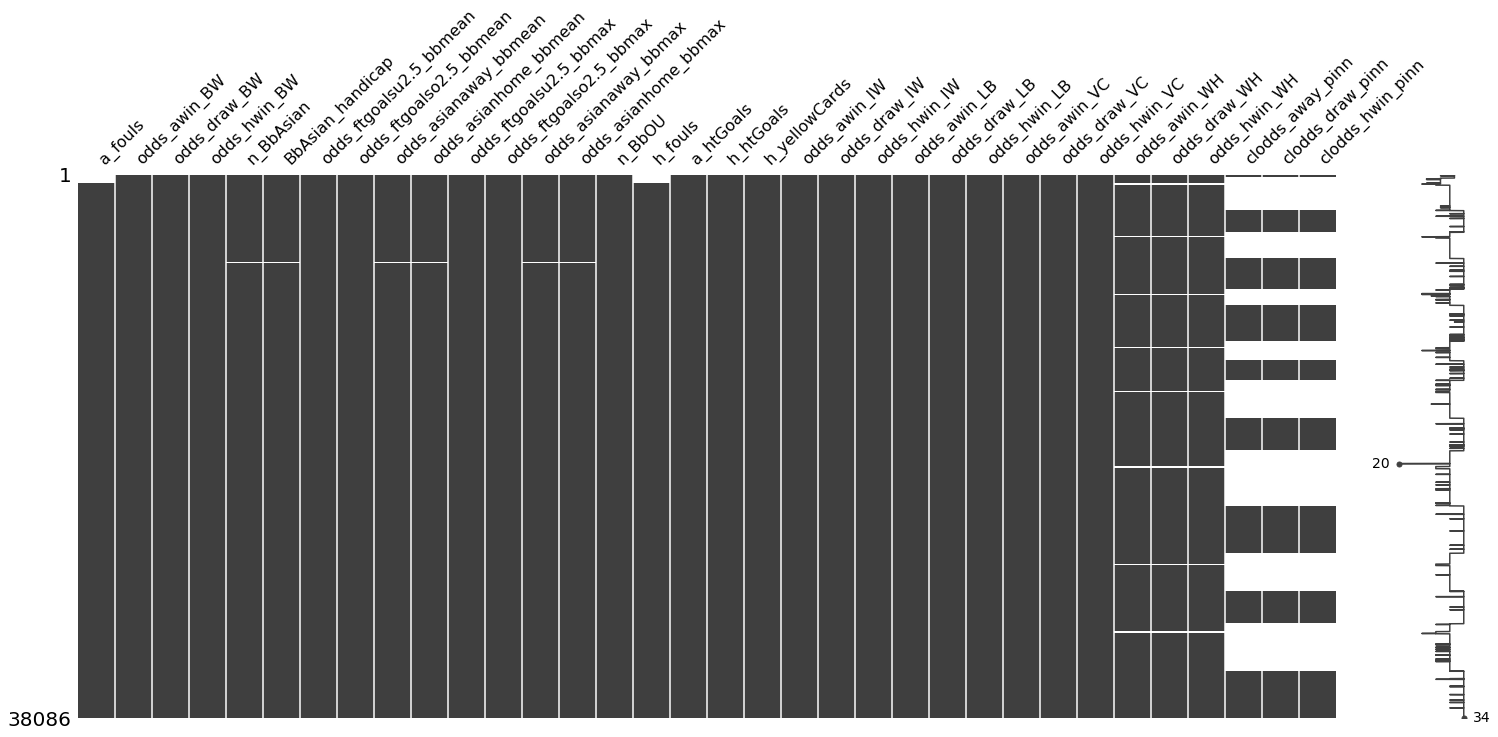

In [39]:
msno.matrix(df[df.columns[df.isnull().any()]])
plt.show();

In [40]:
df['nation'].value_counts()

united-kingdom    18740
spain              4940
germany            3978
france             3800
italy              3040
scotland           2736
netherlands         306
portugal            306
belgium             240
Name: nation, dtype: int64

In [41]:
df['league'].value_counts()

english-championship      7176
one                       6624
la-liga                   4940
english-premier-league    4940
ligue-1                   3800
bundesliga                3672
serie-a                   3040
premiership               2736
primeira-liga              306
bundesliga-2               306
eredivisie                 306
first-division-a           240
Name: league, dtype: int64

In [42]:
df['season'].value_counts().sort_index()

2005-2006    2092
2006-2007    2606
2007-2008    3158
2008-2009    2550
2009-2010    2778
2010-2011    2778
2011-2012    3158
2012-2013    2778
2013-2014    3158
2014-2015    3158
2015-2016    2778
2016-2017    2778
2017-2018    4316
Name: season, dtype: int64

In [43]:
for (nation, league, season), seas_df in df.groupby(by=['nation', 'league', 'season']):
    season_df = seas_df.copy(deep=True)
    season_df.sort_values(by=['date'], inplace=True)
    season_df.reset_index(drop=True, inplace=True)
    fn = season + '.csv'
    source = 'football-data-co-uk'
    save_dir = CLEANED_DIR / source / nation / league / season
    save_fp = save_dir / fn
    save_dir.mkdir(parents=True, exist_ok=True)
    season_df.to_csv(save_fp, index=False)

In [44]:
season_df.head()

,a_corners,a_fouls,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,a,odds_awin_bet365,odds_draw_bet365,odds_hwin_bet365,odds_awin_BW,odds_draw_BW,odds_hwin_BW,n_Bb1X2,n_BbAsian,BbAsian_handicap,odds_ftgoalsu2.5_bbmean,odds_ftgoalso2.5_bbmean,odds_awin_bbmean,odds_asianaway_bbmean,odds_asianhome_bbmean,odds_draw_bbmean,odds_hwin_bbmean,odds_ftgoalsu2.5_bbmax,odds_ftgoalso2.5_bbmax,odds_awin_bbmax,odds_asianaway_bbmax,odds_asianhome_bbmax,odds_draw_bbmax,odds_hwin_bbmax,n_BbOU,date,a_ftGoals,h_ftGoals,ftResult,h_corners,h_fouls,h_redCards,h_shots,h_shotsOnTarget,a_htGoals,h_htGoals,h_yellowCards,h,odds_awin_IW,odds_draw_IW,odds_hwin_IW,odds_awin_LB,odds_draw_LB,odds_hwin_LB,odds_awin_VC,odds_draw_VC,odds_hwin_VC,odds_awin_WH,odds_draw_WH,odds_hwin_WH,league,nation,season,clodds_away_pinn,clodds_draw_pinn,clodds_hwin_pinn
0,3.0,9.0,0.0,9.0,3.0,2.0,Blackpool,6.50,4.0,1.62,5.50,3.70,1.62,40.0,16.0,-0.75,1.64,2.19,5.88,2.04,1.81,3.62,1.62,1.73,2.29,6.88,2.08,1.86,4.00,1.67,36.0,2017-08-05,1.0,2.0,H,3.0,7.0,0.0,15.0,4.0,1.0,1.0,1.0,Bradford,5.50,3.50,1.55,6.0,3.60,1.61,6.0,3.9,1.62,6.00,3.4,1.67,one,united-kingdom,2017-2018,5.50,3.97,1.69
1,3.0,17.0,0.0,7.0,2.0,3.0,Blackburn,2.60,3.4,2.90,2.50,3.25,2.75,39.0,15.0,0.00,1.73,2.06,2.57,1.86,1.99,3.18,2.75,1.83,2.16,2.65,1.91,2.05,3.40,2.90,38.0,2017-08-05,1.0,2.0,H,6.0,10.0,0.0,15.0,7.0,0.0,2.0,0.0,Southend,2.50,3.10,2.65,2.5,3.10,2.75,2.6,3.4,2.75,2.62,3.1,2.80,one,united-kingdom,2017-2018,2.56,3.36,2.96
2,4.0,17.0,0.0,5.0,1.0,1.0,Northampton,3.00,3.4,2.50,2.80,3.25,2.45,40.0,13.0,-0.25,1.75,2.03,2.89,1.79,2.07,3.23,2.42,1.83,2.12,3.04,1.83,2.12,3.41,2.50,39.0,2017-08-05,0.0,1.0,H,7.0,17.0,0.0,12.0,2.0,0.0,0.0,2.0,Shrewsbury,2.80,3.10,2.35,2.9,3.10,2.35,3.0,3.4,2.40,2.90,3.2,2.50,one,united-kingdom,2017-2018,2.90,3.43,2.57
3,7.0,9.0,0.0,15.0,4.0,1.0,AFC Wimbledon,4.10,3.5,2.00,4.33,3.50,1.80,40.0,16.0,-0.50,1.74,2.04,3.94,1.90,1.95,3.38,1.92,1.82,2.13,4.42,1.95,2.03,3.53,2.03,39.0,2017-08-05,1.0,1.0,D,1.0,15.0,0.0,12.0,6.0,0.0,1.0,0.0,Scunthorpe,3.80,3.30,1.85,4.2,3.30,1.83,4.0,3.5,2.00,4.33,3.5,1.83,one,united-kingdom,2017-2018,3.89,3.46,2.09
4,11.0,16.0,0.0,16.0,6.0,2.0,Plymouth,3.75,3.6,2.10,3.50,3.40,2.05,40.0,12.0,-0.50,1.83,1.94,3.51,1.79,2.07,3.36,2.06,1.92,2.03,3.80,1.83,2.12,3.60,2.11,39.0,2017-08-05,1.0,2.0,H,2.0,13.0,0.0,17.0,8.0,0.0,1.0,2.0,Peterboro,3.45,3.25,2.00,3.4,3.25,2.05,3.5,3.6,2.10,3.40,3.4,2.10,one,united-kingdom,2017-2018,3.57,3.64,2.13


In [45]:
season_df.tail()

,a_corners,a_fouls,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,a,odds_awin_bet365,odds_draw_bet365,odds_hwin_bet365,odds_awin_BW,odds_draw_BW,odds_hwin_BW,n_Bb1X2,n_BbAsian,BbAsian_handicap,odds_ftgoalsu2.5_bbmean,odds_ftgoalso2.5_bbmean,odds_awin_bbmean,odds_asianaway_bbmean,odds_asianhome_bbmean,odds_draw_bbmean,odds_hwin_bbmean,odds_ftgoalsu2.5_bbmax,odds_ftgoalso2.5_bbmax,odds_awin_bbmax,odds_asianaway_bbmax,odds_asianhome_bbmax,odds_draw_bbmax,odds_hwin_bbmax,n_BbOU,date,a_ftGoals,h_ftGoals,ftResult,h_corners,h_fouls,h_redCards,h_shots,h_shotsOnTarget,a_htGoals,h_htGoals,h_yellowCards,h,odds_awin_IW,odds_draw_IW,odds_hwin_IW,odds_awin_LB,odds_draw_LB,odds_hwin_LB,odds_awin_VC,odds_draw_VC,odds_hwin_VC,odds_awin_WH,odds_draw_WH,odds_hwin_WH,league,nation,season,clodds_away_pinn,clodds_draw_pinn,clodds_hwin_pinn
547,4.0,13.0,0.0,10.0,7.0,1.0,Wigan,1.72,3.89,5.25,1.67,3.75,5.00,43.0,20.0,0.75,1.82,1.95,1.66,1.84,1.97,3.68,5.14,1.91,2.04,1.73,1.91,2.04,3.90,5.76,39.0,2018-05-05,1.0,0.0,A,0.0,7.0,0.0,2.0,0.0,0.0,0.0,0.0,Doncaster,1.60,3.50,4.95,1.67,3.70,5.25,1.67,3.9,5.4,1.73,3.5,5.0,one,united-kingdom,2017-2018,1.61,4.23,5.75
548,8.0,3.0,0.0,11.0,5.0,0.0,Bury,4.75,3.79,1.80,4.40,3.50,1.80,41.0,20.0,-0.75,1.86,1.90,4.49,1.83,1.98,3.60,1.75,1.95,1.99,4.82,1.88,2.06,3.85,1.80,37.0,2018-05-05,2.0,2.0,D,10.0,11.0,0.0,8.0,4.0,0.0,2.0,1.0,AFC Wimbledon,4.30,3.40,1.70,4.60,3.60,1.75,4.50,3.8,1.8,4.50,3.5,1.8,one,united-kingdom,2017-2018,3.89,3.74,1.98
549,1.0,14.0,0.0,6.0,3.0,1.0,Milton Keynes Dons,4.50,4.00,1.80,4.25,3.60,1.78,42.0,17.0,-0.75,1.77,2.00,4.36,1.80,2.03,3.54,1.78,1.84,2.10,4.80,1.84,2.12,4.00,1.84,37.0,2018-05-05,1.0,0.0,A,7.0,15.0,0.0,8.0,1.0,0.0,0.0,1.0,Shrewsbury,4.20,3.35,1.75,4.50,3.50,1.80,4.50,3.8,1.8,4.50,3.5,1.8,one,united-kingdom,2017-2018,4.98,3.84,1.76
550,1.0,8.0,0.0,8.0,4.0,1.0,Plymouth,2.45,3.50,3.00,2.30,3.40,2.90,43.0,19.0,0.25,1.82,1.95,2.42,2.11,1.74,3.31,2.82,1.90,2.02,2.55,2.20,1.80,3.50,3.00,39.0,2018-05-05,2.0,5.0,H,3.0,15.0,0.0,13.0,7.0,1.0,3.0,2.0,Gillingham,2.30,3.15,2.75,2.45,3.25,2.80,2.50,3.5,2.8,2.40,3.2,3.0,one,united-kingdom,2017-2018,2.79,3.51,2.59
551,2.0,9.0,1.0,6.0,2.0,1.0,Bristol Rvs,3.20,3.60,2.29,3.10,3.40,2.20,42.0,19.0,-0.25,1.98,1.79,3.03,1.87,1.95,3.42,2.23,2.09,1.88,3.20,1.95,2.03,3.65,2.31,37.0,2018-05-05,0.0,0.0,D,9.0,14.0,0.0,19.0,5.0,0.0,0.0,2.0,Southend,2.95,3.25,2.15,3.00,3.40,2.25,3.10,3.6,2.3,3.10,3.2,2.3,one,united-kingdom,2017-2018,3.16,3.78,2.23


In [46]:
season_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 62 columns):
a_corners                  552 non-null float64
a_fouls                    552 non-null float64
a_redCards                 552 non-null float64
a_shots                    552 non-null float64
a_shotsOnTarget            552 non-null float64
a_yellowCards              552 non-null float64
a                          552 non-null object
odds_awin_bet365           552 non-null float64
odds_draw_bet365           552 non-null float64
odds_hwin_bet365           552 non-null float64
odds_awin_BW               552 non-null float64
odds_draw_BW               552 non-null float64
odds_hwin_BW               552 non-null float64
n_Bb1X2                    552 non-null float64
n_BbAsian                  552 non-null float64
BbAsian_handicap           552 non-null float64
odds_ftgoalsu2.5_bbmean    552 non-null float64
odds_ftgoalso2.5_bbmean    552 non-null float64
odds_awin_bbmean           552 n

In [47]:
season_df.describe()

,a_corners,a_fouls,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,odds_awin_bet365,odds_draw_bet365,odds_hwin_bet365,odds_awin_BW,odds_draw_BW,odds_hwin_BW,n_Bb1X2,n_BbAsian,BbAsian_handicap,odds_ftgoalsu2.5_bbmean,odds_ftgoalso2.5_bbmean,odds_awin_bbmean,odds_asianaway_bbmean,odds_asianhome_bbmean,odds_draw_bbmean,odds_hwin_bbmean,odds_ftgoalsu2.5_bbmax,odds_ftgoalso2.5_bbmax,odds_awin_bbmax,odds_asianaway_bbmax,odds_asianhome_bbmax,odds_draw_bbmax,odds_hwin_bbmax,n_BbOU,a_ftGoals,h_ftGoals,h_corners,h_fouls,h_redCards,h_shots,h_shotsOnTarget,a_htGoals,h_htGoals,h_yellowCards,odds_awin_IW,odds_draw_IW,odds_hwin_IW,odds_awin_LB,odds_draw_LB,odds_hwin_LB,odds_awin_VC,odds_draw_VC,odds_hwin_VC,odds_awin_WH,odds_draw_WH,odds_hwin_WH,clodds_away_pinn,clodds_draw_pinn
count,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000
mean,4.911232,11.692029,0.079710,10.340580,3.929348,1.617754,3.603080,3.610562,2.507862,3.401975,3.448931,2.391902,37.425725,16.847826,-0.242301,1.824493,1.974330,3.393569,1.900181,1.942663,3.436486,2.426522,1.903569,2.059837,3.691884,1.958080,2.003388,3.669946,2.561377,34.534420,1.155797,1.382246,5.721014,10.925725,0.072464,12.387681,4.610507,0.485507,0.617754,1.315217,3.240580,3.292754,2.346214,3.430471,3.380272,2.447627,3.468152,3.595906,2.476196,3.444783,3.390272,2.444982,3.636359,3.638062
std,2.559864,4.021188,0.277704,4.071496,2.242246,1.206716,1.488946,0.333119,0.888343,1.280435,0.294338,0.760629,2.688604,2.012311,0.431895,0.158451,0.182682,1.294896,0.111728,0.115392,0.297676,0.791954,0.174474,0.198648,1.560785,0.117526,0.124597,0.353318,0.912095,3.010974,1.094949,1.140212,2.925895,3.370620,0.266392,4.613370,2.434350,0.692039,0.785931,1.139262,1.148838,0.281656,0.746725,1.368296,0.307019,0.814147,1.367264,0.324658,0.835696,1.344456,0.295175,0.804351,1.534716,0.400340
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.450000,3.100000,1.300000,1.440000,3.000000,1.280000,31.000000,10.000000,-1.500000,1.430000,1.550000,1.430000,1.620000,1.640000,2.890000,1.270000,1.480000,1.620000,1.460000,1.670000,1.670000,3.100000,1.320000,26.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.400000,2.750000,1.250000,1.440000,2.900000,1.280000,1.450000,3.100000,1.290000,1.440000,2.880000,1.250000,1.450000,2.820000
25%,3.000000,9.000000,0.000000,7.000000,2.000000,1.000000,2.700000,3.390000,1.950000,2.600000,3.300000,1.900000,35.000000,16.000000,-0.500000,1.720000,1.850000,2.607500,1.820000,1.857500,3.260000,1.940000,1.780000,1.930000,2.750000,1.870000,1.910000,3.490000,2.000000,32.000000,0.000000,1.000000,4.000000,8.000000,0.000000,9.000000,3.000000,0.000000,0.000000,0.000000,2.500000,3.150000,1.870000,2.600000,3.200000,1.950000,2.630000,3.400000,1.950000,2.620000,3.200000,1.950000,2.677500,3.400000
50%,5.000000,11.000000,0.000000,10.000000,4.000000,1.000000,3.200000,3.500000,2.370000,3.100000,3.400000,2.250000,38.000000,17.000000,-0.250000,1.810000,1.970000,3.060000,1.895000,1.940000,3.360000,2.290000,1.880000,2.050000,3.290000,1.950000,2.000000,3.600000,2.400000,35.000000,1.000000,1.000000,5.000000,11.000000,0.000000,12.000000,4.000000,0.000000,0.000000,1.000000,2.950000,3.200000,2.200000,3.100000,3.300000,2.300000,3.130000,3.500000,2.340000,3.100000,3.300000,2.300000,3.265000,3.560000
75%,6.000000,14.000000,0.000000,13.000000,5.000000,2.000000,4.200000,3.700000,2.790000,3.900000,3.500000,2.650000,39.000000,18.000000,0.000000,1.9200

## Test Read

In [48]:
df = pd.read_csv(save_fp, parse_dates=['date'], index_col=None)
df.head()

,a_corners,a_fouls,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,a,odds_awin_bet365,odds_draw_bet365,odds_hwin_bet365,odds_awin_BW,odds_draw_BW,odds_hwin_BW,n_Bb1X2,n_BbAsian,BbAsian_handicap,odds_ftgoalsu2.5_bbmean,odds_ftgoalso2.5_bbmean,odds_awin_bbmean,odds_asianaway_bbmean,odds_asianhome_bbmean,odds_draw_bbmean,odds_hwin_bbmean,odds_ftgoalsu2.5_bbmax,odds_ftgoalso2.5_bbmax,odds_awin_bbmax,odds_asianaway_bbmax,odds_asianhome_bbmax,odds_draw_bbmax,odds_hwin_bbmax,n_BbOU,date,a_ftGoals,h_ftGoals,ftResult,h_corners,h_fouls,h_redCards,h_shots,h_shotsOnTarget,a_htGoals,h_htGoals,h_yellowCards,h,odds_awin_IW,odds_draw_IW,odds_hwin_IW,odds_awin_LB,odds_draw_LB,odds_hwin_LB,odds_awin_VC,odds_draw_VC,odds_hwin_VC,odds_awin_WH,odds_draw_WH,odds_hwin_WH,league,nation,season,clodds_away_pinn,clodds_draw_pinn,clodds_hwin_pinn
0,3.0,9.0,0.0,9.0,3.0,2.0,Blackpool,6.50,4.0,1.62,5.50,3.70,1.62,40.0,16.0,-0.75,1.64,2.19,5.88,2.04,1.81,3.62,1.62,1.73,2.29,6.88,2.08,1.86,4.00,1.67,36.0,2017-08-05,1.0,2.0,H,3.0,7.0,0.0,15.0,4.0,1.0,1.0,1.0,Bradford,5.50,3.50,1.55,6.0,3.60,1.61,6.0,3.9,1.62,6.00,3.4,1.67,one,united-kingdom,2017-2018,5.50,3.97,1.69
1,3.0,17.0,0.0,7.0,2.0,3.0,Blackburn,2.60,3.4,2.90,2.50,3.25,2.75,39.0,15.0,0.00,1.73,2.06,2.57,1.86,1.99,3.18,2.75,1.83,2.16,2.65,1.91,2.05,3.40,2.90,38.0,2017-08-05,1.0,2.0,H,6.0,10.0,0.0,15.0,7.0,0.0,2.0,0.0,Southend,2.50,3.10,2.65,2.5,3.10,2.75,2.6,3.4,2.75,2.62,3.1,2.80,one,united-kingdom,2017-2018,2.56,3.36,2.96
2,4.0,17.0,0.0,5.0,1.0,1.0,Northampton,3.00,3.4,2.50,2.80,3.25,2.45,40.0,13.0,-0.25,1.75,2.03,2.89,1.79,2.07,3.23,2.42,1.83,2.12,3.04,1.83,2.12,3.41,2.50,39.0,2017-08-05,0.0,1.0,H,7.0,17.0,0.0,12.0,2.0,0.0,0.0,2.0,Shrewsbury,2.80,3.10,2.35,2.9,3.10,2.35,3.0,3.4,2.40,2.90,3.2,2.50,one,united-kingdom,2017-2018,2.90,3.43,2.57
3,7.0,9.0,0.0,15.0,4.0,1.0,AFC Wimbledon,4.10,3.5,2.00,4.33,3.50,1.80,40.0,16.0,-0.50,1.74,2.04,3.94,1.90,1.95,3.38,1.92,1.82,2.13,4.42,1.95,2.03,3.53,2.03,39.0,2017-08-05,1.0,1.0,D,1.0,15.0,0.0,12.0,6.0,0.0,1.0,0.0,Scunthorpe,3.80,3.30,1.85,4.2,3.30,1.83,4.0,3.5,2.00,4.33,3.5,1.83,one,united-kingdom,2017-2018,3.89,3.46,2.09
4,11.0,16.0,0.0,16.0,6.0,2.0,Plymouth,3.75,3.6,2.10,3.50,3.40,2.05,40.0,12.0,-0.50,1.83,1.94,3.51,1.79,2.07,3.36,2.06,1.92,2.03,3.80,1.83,2.12,3.60,2.11,39.0,2017-08-05,1.0,2.0,H,2.0,13.0,0.0,17.0,8.0,0.0,1.0,2.0,Peterboro,3.45,3.25,2.00,3.4,3.25,2.05,3.5,3.6,2.10,3.40,3.4,2.10,one,united-kingdom,2017-2018,3.57,3.64,2.13


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 62 columns):
a_corners                  552 non-null float64
a_fouls                    552 non-null float64
a_redCards                 552 non-null float64
a_shots                    552 non-null float64
a_shotsOnTarget            552 non-null float64
a_yellowCards              552 non-null float64
a                          552 non-null object
odds_awin_bet365           552 non-null float64
odds_draw_bet365           552 non-null float64
odds_hwin_bet365           552 non-null float64
odds_awin_BW               552 non-null float64
odds_draw_BW               552 non-null float64
odds_hwin_BW               552 non-null float64
n_Bb1X2                    552 non-null float64
n_BbAsian                  552 non-null float64
BbAsian_handicap           552 non-null float64
odds_ftgoalsu2.5_bbmean    552 non-null float64
odds_ftgoalso2.5_bbmean    552 non-null float64
odds_awin_bbmean           552 n

In [50]:
stop

NameError: name 'stop' is not defined

## End

In [ ]:
df_orig[1].value_counts()

In [ ]:
# In order to clean up the data, we have to see all the seaons together, so we can see 
# what data is missing across the full scope of the data
# Therefore, compile everything together and take a look
leagues = ['english-premier-league', 'la-liga', 'bundesliga', 'serie-a', 'ligue-1', 'primeira-liga',
           'russian-premier-league', 'ukranian-premier-league', 'eredivisie', 'superleague', 'super-lig',
           'superliga', 'belgian-pro-league'
all_fps = []
for league in leagues:
fps = form_fdcu_fps(RAW_DATA_DIR, source, nation, league, seasons)
season_dfs=[]
for season, fp in zip(seasons, fps):
    # Note: dayfirst=True
    season_df = pd.read_csv(fp, dayfirst=True, parse_dates=['Date'])
    # Add the season to help navigate the merged dataframe
    season_df['season'] = season
    season_dfs.append(season_df)

df = pd.concat(season_dfs, axis=0, sort=True)
df = df.sort_values(by='Date')
    
df.head()

In [ ]:
df.info()

## Review Complete, Partially Complete Data

In [ ]:
df_full = df[df.columns[~df.isnull().any()]]
df_full.info()

In [ ]:
df_with_nulls = df[df.columns[df.isnull().any()]]

In [ ]:
msno.matrix(df_with_nulls)
plt.show();

In [ ]:
# Looks like the data is missing based on the season
# The Pinnacle closing odds data PSCA, PSCD, PSCH is missing for the first few seasons which is disappointing
# But even with missing values, we will leave move this data onto the next stage
# BbAH, BBAvAHA, BBAvAHH, BbMxAHA, and BbMXAHH have got more than 99% of their data 
# ie 3410/3420 = 0.997, so we will keep these columns

In [ ]:
# drop_threshold = 0.995
# df.info().index
# #droppers = ['BSA']
df.dropna(thresh=df.shape[0]*0.6,how='all',axis=1)

In [ ]:
stop

In [ ]:
df_read = pd.read_csv(INTERIM_DATA_DIR / league / save_file_name,
                      parse_dates=['date'], index_col=None)
df.head()

In [ ]:
# Grab the first data file and take a look
fp1 = form_fdcu_fps(RAW_DATA_DIR, source, nation, league, seasons)[0]
fp1

In [ ]:
league = 'english-premier-league'
GAME_DATA_DIR = RAW_DATA_DIR / 'football-data' / 'United-Kingdom' / league

# seasons 2009-2010 through to 2017-2018
start_year = 2009 ; end_year = 2018
seasons = [str(year) + '-' + str(year+1) for year in range(start_year, end_year)]
print(GAME_DATA_DIR)
save_file_name = str('football-data-' + league + '.csv')

In [ ]:
# Compile Seasons into one file
season_dfs=[]
for season in seasons:
    season_fp = GAME_DATA_DIR / season / 'football-data-co-uk' / 'season-data' / str(season + '.csv')
#     season_dfs = pd.read_csv(season_fp)
#     print(season_df.head())
    season_df = pd.read_csv(season_fp, dayfirst=True, parse_dates=['Date'])
    season_df['season'] = season
    season_dfs.append(season_df)

df = pd.concat(season_dfs, axis=0, sort=True)
    
df.head()

In [ ]:
seasons_df = df.copy(deep=True)

# Drop unnecesary columns
# Referee is not available for the full data set, and Half Time Result and Full Time Result can be calculated
seasons_df.drop(columns=['Div', 'FTR', 'HTR', 'Referee', ], inplace=True)
seasons_df.rename(columns={'Date': 'date', 'HomeTeam': 'h', 'AwayTeam': 'a',
                          'FTHG': 'h_ftgoals', 'FTAG': 'a_ftgoals', 'HTHG': 'h_htgoals', 'HTAG': 'a_htgoals',
                         'HS': 'h_shots', 'AS': 'a_shots', 'HST': 'h_sot', 'AST': 'a_sot',
                         'HF': 'h_fouls', 'AF': 'a_fouls', 'HC': 'h_corners', 'AC': 'a_corners',
                         'HY': 'h_ycards', 'AY': 'a_ycards', 'HR': 'h_rcards', 'AR': 'a_rcards'}, inplace=True)

columns = {'B365H': 'odds_hwin_bet365', 'B365D': 'odds_draw_bet365', 'B365A': 'odds_awin_bet365',
          'BWH': 'odds_hwin_BW', 'BWD': 'odds_draw_BW', 'BWA': 'odds_awin_BW',
          'GBH': 'odds_hwin_GB', 'GBD': 'odds_draw_GB', 'GBA': 'odds_awin_GB',
          'IWH': 'odds_hwin_IW', 'IWD': 'odds_draw_IW', 'IWA': 'odds_awin_IW',
          'LBH': 'odds_hwin_LB', 'LBD': 'odds_draw_LB', 'LBA': 'odds_awin_LB',
          'SBH': 'odds_hwin_SB', 'SBD': 'odds_draw_SB', 'SBA': 'odds_awin_SB',
          'WHH': 'odds_hwin_WH', 'WHD': 'odds_draw_WH', 'WHA': 'odds_awin_WH',
          'SJH': 'odds_hwin_SJ', 'SJD': 'odds_draw_SJ', 'SJA': 'odds_awin_SJ',
          'VCH': 'odds_hwin_VC', 'VCD': 'odds_draw_VC', 'VCA': 'odds_awin_VC',           
          'BSH': 'odds_hwin_BS', 'BSD': 'odds_draw_BS', 'BSA': 'odds_awin_BS',
          'PSH': 'odds_hwin_pinn', 'PSD': 'odds_draw_pinn', 'PSA': 'odds_awin_pinn',
           'Bb1X2': 'n_Bb1X2',
           'BbMxH': 'odds_hwin_bbmax', 'BbMxD': 'odds_draw_bbmax', 'BbMxA': 'odds_awin_bbmax',
           'BbAvH': 'odds_hwin_bbmean', 'BbAvD': 'odds_draw_bbmean', 'BbAvA': 'odds_awin_bbmean',
           'BbOU': 'n_BbOU',
           'BbMx>2.5': 'odds_ftgoalso2.5_bbmax', 'BbAv>2.5': 'odds_ftgoalso2.5_bbmean',
           'BbMx<2.5': 'odds_ftgoalsu2.5_bbmax', 'BbAv<2.5': 'odds_ftgoalsu2.5_bbmean',
           'BbAH': 'n_BbAsian',
           'BbAHh': 'BbAsian_handicap',
           'BbMxAHH': 'odds_asianhome_bbmax', 'BbAvAHH': 'odds_asianhome_bbmean',
           'BbMxAHH': 'odds_asianhome_bbmax', 'BbAvAHH': 'odds_asianhome_bbmean',
           'BbMxAHA': 'odds_asianaway_bbmax', 'BbAvAHH': 'odds_asianaway_bbmean',
           'BbMxAHA': 'odds_asianaway_bbmax', 'BbAvAHA': 'odds_asianaway_bbmean',
           'PSCH': 'clodds_hwin_pinn', 'PSCD': 'clodds_draw_pinn', 'PSCA': 'clodds_away_pinn'}
seasons_df.rename(columns=columns, inplace=True)


seasons_df.head()

In [ ]:
seasons_df.describe()

In [ ]:
seasons_df.info()

In [ ]:
seasons_df.to_csv(INTERIM_DATA_DIR / league / save_file_name, index=False)

## Read Back Data

In [ ]:
df = pd.read_csv(INTERIM_DATA_DIR / league / save_file_name,
                      parse_dates=['date'], index_col=None)
df.head()

In [ ]:
df.info()